In [ ]:
import torch
import torchvision
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/drive/My Drive/Image based Colorectal Cancer diagnosis/dataset.zip" "dataset.zip"

In [ ]:
!unzip -q dataset.zip
!unzip -q dataset/dualclass.zip
!unzip -q dataset/test2classes.zip

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

class MobileNetV1(nn.Module):
    def __init__(self, input_channel, n_classes):
        super().__init__()

        def pointwise(input, output, stride):
            return nn.Sequential(
                nn.Conv2d(input, output, 3, stride, 1, bias=False),
                nn.BatchNorm2d(output),
                nn.ReLU(inplace=True)
                )

        def depthwise(input, output, stride):
            return nn.Sequential(
                
                nn.Conv2d(input, input, 3, stride, 1, groups=input, bias=False),
                nn.BatchNorm2d(input),
                nn.ReLU(inplace=True),

                
                nn.Conv2d(input, output, 1, 1, 0, bias=False),
                nn.BatchNorm2d(output),
                nn.ReLU(inplace=True),
                )

        self.model = nn.Sequential(
            pointwise(input_channel, 32, 2),
            depthwise(32, 64, 1),
            depthwise(64, 128, 2),
            depthwise(128, 128, 1),
            depthwise(128, 256, 2),
            depthwise(256, 256, 1),
            depthwise(256, 512, 2),
            depthwise(512, 512, 1),
            depthwise(512, 512, 1),
            depthwise(512, 512, 1),
            depthwise(512, 512, 1),
            depthwise(512, 512, 1),
            depthwise(512, 1024, 2),
            depthwise(1024, 1024, 1),
            nn.AvgPool2d(7)
        )
        self.fc = nn.Linear(1024, n_classes)

        self.model.apply(self.initialw)
        self.fc.apply(self.initialw)

    def initialw(self, layer):
        if type(layer) == nn.Conv2d:
            nn.init.kaiming_normal_(layer.weight, mode='fan_out')
        if type(layer) == nn.Linear:
            nn.init.normal_(layer.weight, std=1e-3)
        if type(layer) == nn.BatchNorm2d:
            nn.init.constant_(layer.weight, 1)
            nn.init.constant_(layer.bias, 0)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x


In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
from tqdm import tqdm_notebook as tqdm
##define train function
def train(model, device, train_loader, optimizer):
    # meter
    loss = AverageMeter()
    # switch to train mode
    model.train()
    tk0 = tqdm(train_loader, total=int(len(train_loader)))
    for batch_idx, (data, target) in enumerate(tk0):
        
        data, target = data.to(device), target.to(device)  
        
        output = model(data) 
        # compute the loss function
        loss_this = F.cross_entropy(output, target)
        # initialize the optimizer
        optimizer.zero_grad()
        # compute the backward pass
        loss_this.backward()
        # update the parameters
        optimizer.step()
        # update the loss meter 
        loss.update(loss_this.item(), target.shape[0])
    print('Train: Average loss: {:.4f}\n'.format(loss.avg))
    return loss.avg    


def validate(model, device, val_loader):
    # meters
    loss = AverageMeter()
    acc = AverageMeter()
    correct = 0
    # switch to test mode
    model.eval()
    for data, target in val_loader:
      
        data, target = data.to(device), target.to(device)  
        with torch.no_grad():
            
            output = model(data)
       
        loss_this = F.cross_entropy(output, target) 
        # get the index of the max log-probability
        pred = output.argmax(dim=1, keepdim=True) 
        # check which are correct
        correct_this = pred.eq(target.view_as(pred)).sum().item()
        # accumulate the correct ones
        correct += correct_this
        # compute accuracy
        acc_this = correct_this/target.shape[0]*100.0
        # update the loss and accuracy meter 
        acc.update(acc_this, target.shape[0])
        loss.update(loss_this.item(), target.shape[0])
    print('Test: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        loss.avg, correct, len(val_loader.dataset), acc.avg))
    return loss.avg,acc.avg
##define test function

def test(model, device, test_loader):
    # meters
    loss = AverageMeter()
    acc = AverageMeter()
    correct = 0
    # switch to test mode
    model.eval()
    for data, target in test_loader:
      
        data, target = data.to(device), target.to(device)  
        with torch.no_grad():
            
            output = model(data)
       
        loss_this = F.cross_entropy(output, target) 
        # get the index of the max log-probability
        pred = output.argmax(dim=1, keepdim=True) 
        # check which are correct
        correct_this = pred.eq(target.view_as(pred)).sum().item()
        # accumulate the correct ones
        correct += correct_this
        # compute accuracy
        acc_this = correct_this/target.shape[0]*100.0
        # update the loss and accuracy meter 
        acc.update(acc_this, target.shape[0])
        loss.update(loss_this.item(), target.shape[0])
    print('Test: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        loss.avg, correct, len(test_loader.dataset), acc.avg))
    return loss.avg,acc.avg

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
with open('dualclass/files_list.txt', 'r') as fp:
    files = fp.read().splitlines()
classes_str = [file.split('/')[0] for file in files]
classes_str, classes = np.unique(classes_str, return_inverse=True)
print(classes_str)
train_files, val_files, train_classes, val_classes = train_test_split(files, classes, train_size=0.7, test_size=0.3, stratify=classes)

['NORM' 'TUM']


In [ ]:
with open('test2classes/files_list.txt', 'r') as fp:
    files = fp.read().splitlines()
classes_str = [file.split('/')[0] for file in files]
classes_str, classes = np.unique(classes_str, return_inverse=True)
print(classes_str)
test_files=files
test_classes = classes
print(len(test_files))
print(len(test_classes))

['NORM' 'TUM']
7200
7200


In [ ]:
from PIL import Image
import torch.utils.data as data
class Hist(data.Dataset):
    def __init__(self, root, files, classes, transforms=None):
        self.root = root
        self.files = files
        self.classes = classes
        self.transforms = transforms

    def __getitem__(self, item):
        image = Image.open(os.path.join(self.root, self.files[item])).convert(mode="RGB")
        class_ = self.classes[item]
        if self.transforms:
            image = self.transforms(image)
        return image, class_

    def __len__(self):
        return len(self.files)

In [ ]:
batch_size_train = 5 # We use a small batch size here for training
batch_size_test = 10 #
batch_size_val = 10

# define how image transformed
image_transform = torchvision.transforms.Compose([
                               torchvision.transforms.Resize((224, 224)),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#image datasets
train_dataset = Hist('dualclass/', train_files, train_classes, 
                         transforms=image_transform)
val_dataset = Hist('dualclass/', val_files, val_classes, 
                         transforms=image_transform)
test_dataset = Hist('test2classes/', test_files, test_classes, 
                        transforms=image_transform)
#data loaders
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size_train, 
                                           shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset,
                                           batch_size=batch_size_val, 
                                           shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size_test, 
                                          shuffle=True, num_workers=2)

Label: TUM


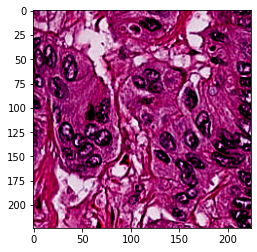

In [ ]:
# import library
import matplotlib.pyplot as plt
# We can check the dataloader
_, (example_datas, labels) = next(enumerate(train_loader))
sample = example_datas[0]
# show the data
plt.imshow(sample.permute(1, 2, 0));
print("Label: " + str(classes_str[labels[0]]))

In [ ]:
drive.flush_and_unmount()
!rm -rf /content/drive

In [ ]:
import os.path
from os import path
import torch.nn.functional as F
import torch.optim as optim

num_epoch = 30
accuracy_test=[]

for i in range(5):
  print('Experiment: ', i+1)
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = MobileNetV1(input_channel=3, n_classes=2).to(device)
  learning_rate = 0.0005
  weight_decay = 0.001
  for param in model.parameters():
    param.requires_grad = True
  parameters = filter(lambda p: p.requires_grad, model.parameters())
  optimizer = optim.SGD(parameters, lr=learning_rate, momentum=0.9)

  acc=0
  for epoch in range(1, num_epoch + 1):
    print(epoch)
    tl=train(model, device, train_loader, optimizer)
    stl,acct=validate(model, device, val_loader)
    if acc<acct:
      if path.exists("MobileNet2SGD.pth"):
        os.remove("MobileNet2SGD.pth")
      torch.save(model.state_dict(), 'MobileNet2SGD.pth')
      acc=acct

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = MobileNetV1(input_channel=3, n_classes=2).to(device)
  model.load_state_dict(torch.load('MobileNet2SGD.pth', map_location=device))
  model=model.to(device)
  
  l,a=test(model, device, test_loader)
  accuracy_test.append(a)
print(accuracy_test)

Experiment:  1
1


<ipython-input-6-7ceae6cba87a>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tk0 = tqdm(train_loader, total=int(len(train_loader)))


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.4240

Test: Average loss: 0.9282, Accuracy: 7792/9096 (85.66%)

2


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.3418

Test: Average loss: 0.3231, Accuracy: 8064/9096 (88.65%)

3


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.3233

Test: Average loss: 0.1992, Accuracy: 8445/9096 (92.84%)

4


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.2936

Test: Average loss: 0.2285, Accuracy: 8154/9096 (89.64%)

5


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.2825

Test: Average loss: 0.7368, Accuracy: 7792/9096 (85.66%)

6


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.2688

Test: Average loss: 1.3555, Accuracy: 7960/9096 (87.51%)

7


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.2438

Test: Average loss: 0.4471, Accuracy: 8270/9096 (90.92%)

8


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.2237

Test: Average loss: 0.1186, Accuracy: 8715/9096 (95.81%)

9


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1858

Test: Average loss: 0.0921, Accuracy: 8816/9096 (96.92%)

10


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1698

Test: Average loss: 0.1755, Accuracy: 8593/9096 (94.47%)

11


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1536

Test: Average loss: 0.2675, Accuracy: 8367/9096 (91.99%)

12


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1426

Test: Average loss: 0.1122, Accuracy: 8705/9096 (95.70%)

13


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1305

Test: Average loss: 0.1152, Accuracy: 8702/9096 (95.67%)

14


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1212

Test: Average loss: 0.2788, Accuracy: 8464/9096 (93.05%)

15


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1154

Test: Average loss: 0.1940, Accuracy: 8613/9096 (94.69%)

16


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1022

Test: Average loss: 0.0833, Accuracy: 8831/9096 (97.09%)

17


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0962

Test: Average loss: 0.1961, Accuracy: 8387/9096 (92.21%)

18


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0920

Test: Average loss: 0.0633, Accuracy: 8916/9096 (98.02%)

19


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0933

Test: Average loss: 0.0963, Accuracy: 8772/9096 (96.44%)

20


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0816

Test: Average loss: 0.1352, Accuracy: 8633/9096 (94.91%)

21


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0820

Test: Average loss: 0.0954, Accuracy: 8838/9096 (97.16%)

22


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0793

Test: Average loss: 0.0885, Accuracy: 8751/9096 (96.21%)

23


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0721

Test: Average loss: 0.0989, Accuracy: 8799/9096 (96.73%)

24


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0701

Test: Average loss: 0.0795, Accuracy: 8899/9096 (97.83%)

25


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0691

Test: Average loss: 0.1025, Accuracy: 8757/9096 (96.27%)

26


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0673

Test: Average loss: 0.1301, Accuracy: 8643/9096 (95.02%)

27


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0602

Test: Average loss: 0.0872, Accuracy: 8821/9096 (96.98%)

28


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0540

Test: Average loss: 0.1135, Accuracy: 8813/9096 (96.89%)

29


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0532

Test: Average loss: 0.0757, Accuracy: 8849/9096 (97.28%)

30


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0555

Test: Average loss: 0.0617, Accuracy: 8911/9096 (97.97%)

Test: Average loss: 0.0599, Accuracy: 7056/7200 (98.00%)

Experiment:  2
1


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.4289

Test: Average loss: 0.7169, Accuracy: 7750/9096 (85.20%)

2


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.3401

Test: Average loss: 0.3678, Accuracy: 8108/9096 (89.14%)

3


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.3064

Test: Average loss: 0.5729, Accuracy: 8147/9096 (89.57%)

4


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.3071

Test: Average loss: 0.6187, Accuracy: 8002/9096 (87.97%)

5


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.2914

Test: Average loss: 0.2022, Accuracy: 8444/9096 (92.83%)

6


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.2641

Test: Average loss: 0.5057, Accuracy: 7996/9096 (87.91%)

7


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.2623

Test: Average loss: 0.1545, Accuracy: 8616/9096 (94.72%)

8


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.2339

Test: Average loss: 0.2079, Accuracy: 8610/9096 (94.66%)

9


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.2168

Test: Average loss: 0.2031, Accuracy: 8349/9096 (91.79%)

10


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.2074

Test: Average loss: 0.1326, Accuracy: 8692/9096 (95.56%)

11


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1894

Test: Average loss: 0.0768, Accuracy: 8880/9096 (97.63%)

12


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1630

Test: Average loss: 0.1474, Accuracy: 8626/9096 (94.83%)

13


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1544

Test: Average loss: 0.1216, Accuracy: 8805/9096 (96.80%)

14


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1362

Test: Average loss: 0.0918, Accuracy: 8832/9096 (97.10%)

15


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1179

Test: Average loss: 0.1224, Accuracy: 8792/9096 (96.66%)

16


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1099

Test: Average loss: 0.0741, Accuracy: 8902/9096 (97.87%)

17


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0962

Test: Average loss: 0.1499, Accuracy: 8726/9096 (95.93%)

18


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0911

Test: Average loss: 0.1285, Accuracy: 8672/9096 (95.34%)

19


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0877

Test: Average loss: 0.0713, Accuracy: 8874/9096 (97.56%)

20


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0817

Test: Average loss: 0.0784, Accuracy: 8869/9096 (97.50%)

21


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0779

Test: Average loss: 0.0807, Accuracy: 8844/9096 (97.23%)

22


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0734

Test: Average loss: 0.0632, Accuracy: 8907/9096 (97.92%)

23


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0681

Test: Average loss: 0.0636, Accuracy: 8888/9096 (97.71%)

24


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0637

Test: Average loss: 0.0611, Accuracy: 8908/9096 (97.93%)

25


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0602

Test: Average loss: 0.0825, Accuracy: 8857/9096 (97.37%)

26


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0559

Test: Average loss: 0.0631, Accuracy: 8908/9096 (97.93%)

27


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0539

Test: Average loss: 0.0682, Accuracy: 8901/9096 (97.86%)

28


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0524

Test: Average loss: 0.0705, Accuracy: 8877/9096 (97.59%)

29


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0498

Test: Average loss: 0.0980, Accuracy: 8784/9096 (96.57%)

30


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0437

Test: Average loss: 0.0635, Accuracy: 8917/9096 (98.03%)

Test: Average loss: 0.0429, Accuracy: 7096/7200 (98.56%)

Experiment:  3
1


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.4356

Test: Average loss: 0.7002, Accuracy: 7479/9096 (82.22%)

2


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.3554

Test: Average loss: 0.8610, Accuracy: 7773/9096 (85.46%)

3


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.3148

Test: Average loss: 0.2715, Accuracy: 8127/9096 (89.35%)

4


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.3066

Test: Average loss: 0.3256, Accuracy: 8181/9096 (89.94%)

5


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.2963

Test: Average loss: 0.2234, Accuracy: 8264/9096 (90.85%)

6


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.2743

Test: Average loss: 0.3011, Accuracy: 8398/9096 (92.33%)

7


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.2628

Test: Average loss: 0.4033, Accuracy: 7669/9096 (84.31%)

8


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.2417

Test: Average loss: 0.2498, Accuracy: 8144/9096 (89.53%)

9


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.2260

Test: Average loss: 0.2161, Accuracy: 8375/9096 (92.07%)

10


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1923

Test: Average loss: 0.4626, Accuracy: 8130/9096 (89.38%)

11


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1681

Test: Average loss: 0.1388, Accuracy: 8583/9096 (94.36%)

12


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1449

Test: Average loss: 0.1000, Accuracy: 8770/9096 (96.42%)

13


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1321

Test: Average loss: 0.0913, Accuracy: 8820/9096 (96.97%)

14


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1180

Test: Average loss: 0.0868, Accuracy: 8832/9096 (97.10%)

15


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1163

Test: Average loss: 0.1205, Accuracy: 8691/9096 (95.55%)

16


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1056

Test: Average loss: 0.1334, Accuracy: 8685/9096 (95.48%)

17


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0992

Test: Average loss: 0.0869, Accuracy: 8848/9096 (97.27%)

18


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0881

Test: Average loss: 0.1573, Accuracy: 8624/9096 (94.81%)

19


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0841

Test: Average loss: 0.1139, Accuracy: 8698/9096 (95.62%)

20


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0816

Test: Average loss: 0.0961, Accuracy: 8785/9096 (96.58%)

21


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0799

Test: Average loss: 0.1228, Accuracy: 8820/9096 (96.97%)

22


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0754

Test: Average loss: 0.1215, Accuracy: 8713/9096 (95.79%)

23


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0695

Test: Average loss: 0.0910, Accuracy: 8793/9096 (96.67%)

24


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0641

Test: Average loss: 0.0609, Accuracy: 8922/9096 (98.09%)

25


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0645

Test: Average loss: 0.1147, Accuracy: 8691/9096 (95.55%)

26


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0578

Test: Average loss: 0.0739, Accuracy: 8854/9096 (97.34%)

27


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0542

Test: Average loss: 0.0800, Accuracy: 8846/9096 (97.25%)

28


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0498

Test: Average loss: 0.0745, Accuracy: 8863/9096 (97.44%)

29


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0509

Test: Average loss: 0.0847, Accuracy: 8835/9096 (97.13%)

30


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0492

Test: Average loss: 0.1320, Accuracy: 8723/9096 (95.90%)

Test: Average loss: 0.0636, Accuracy: 7066/7200 (98.14%)

Experiment:  4
1


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.4402

Test: Average loss: 0.4341, Accuracy: 7506/9096 (82.52%)

2


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.3351

Test: Average loss: 0.7003, Accuracy: 7508/9096 (82.54%)

3


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.3053

Test: Average loss: 0.4999, Accuracy: 7963/9096 (87.54%)

4


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.2862

Test: Average loss: 0.1706, Accuracy: 8506/9096 (93.51%)

5


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.2858

Test: Average loss: 0.1883, Accuracy: 8474/9096 (93.16%)

6


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.2577

Test: Average loss: 0.2716, Accuracy: 8352/9096 (91.82%)

7


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.2474

Test: Average loss: 0.3974, Accuracy: 7919/9096 (87.06%)

8


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.2277

Test: Average loss: 0.4478, Accuracy: 7911/9096 (86.97%)

9


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.2339

Test: Average loss: 0.1652, Accuracy: 8502/9096 (93.47%)

10


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1966

Test: Average loss: 0.1225, Accuracy: 8712/9096 (95.78%)

11


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1828

Test: Average loss: 0.1078, Accuracy: 8756/9096 (96.26%)

12


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1567

Test: Average loss: 0.1108, Accuracy: 8758/9096 (96.28%)

13


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1388

Test: Average loss: 0.1531, Accuracy: 8672/9096 (95.34%)

14


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1278

Test: Average loss: 0.1407, Accuracy: 8614/9096 (94.70%)

15


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1219

Test: Average loss: 0.0786, Accuracy: 8862/9096 (97.43%)

16


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1122

Test: Average loss: 0.1108, Accuracy: 8699/9096 (95.64%)

17


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1052

Test: Average loss: 0.0808, Accuracy: 8831/9096 (97.09%)

18


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0983

Test: Average loss: 0.0764, Accuracy: 8872/9096 (97.54%)

19


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0914

Test: Average loss: 0.0867, Accuracy: 8804/9096 (96.79%)

20


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0871

Test: Average loss: 0.0650, Accuracy: 8899/9096 (97.83%)

21


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0839

Test: Average loss: 0.0722, Accuracy: 8873/9096 (97.55%)

22


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0783

Test: Average loss: 0.1997, Accuracy: 8390/9096 (92.24%)

23


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0720

Test: Average loss: 0.1949, Accuracy: 8618/9096 (94.74%)

24


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0701

Test: Average loss: 0.0685, Accuracy: 8864/9096 (97.45%)

25


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0689

Test: Average loss: 0.0716, Accuracy: 8879/9096 (97.61%)

26


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0622

Test: Average loss: 0.1554, Accuracy: 8624/9096 (94.81%)

27


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0605

Test: Average loss: 0.0778, Accuracy: 8839/9096 (97.17%)

28


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0603

Test: Average loss: 0.1267, Accuracy: 8669/9096 (95.31%)

29


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0551

Test: Average loss: 0.0647, Accuracy: 8912/9096 (97.98%)

30


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0523

Test: Average loss: 0.0761, Accuracy: 8853/9096 (97.33%)

Test: Average loss: 0.0501, Accuracy: 7089/7200 (98.46%)

Experiment:  5
1


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.4425

Test: Average loss: 0.5103, Accuracy: 7790/9096 (85.64%)

2


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.3410

Test: Average loss: 0.3520, Accuracy: 8328/9096 (91.56%)

3


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.3121

Test: Average loss: 1.2331, Accuracy: 8015/9096 (88.12%)

4


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.2969

Test: Average loss: 0.3029, Accuracy: 8595/9096 (94.49%)

5


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.2808

Test: Average loss: 0.1477, Accuracy: 8702/9096 (95.67%)

6


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.2581

Test: Average loss: 0.2451, Accuracy: 8424/9096 (92.61%)

7


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.2406

Test: Average loss: 0.3095, Accuracy: 7939/9096 (87.28%)

8


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.2218

Test: Average loss: 0.3735, Accuracy: 8345/9096 (91.74%)

9


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.2057

Test: Average loss: 0.1775, Accuracy: 8577/9096 (94.29%)

10


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1881

Test: Average loss: 0.0979, Accuracy: 8827/9096 (97.04%)

11


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1575

Test: Average loss: 0.1898, Accuracy: 8538/9096 (93.87%)

12


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1438

Test: Average loss: 0.1492, Accuracy: 8697/9096 (95.61%)

13


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1346

Test: Average loss: 0.1404, Accuracy: 8717/9096 (95.83%)

14


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1192

Test: Average loss: 0.1691, Accuracy: 8543/9096 (93.92%)

15


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1019

Test: Average loss: 0.1313, Accuracy: 8791/9096 (96.65%)

16


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1026

Test: Average loss: 0.1963, Accuracy: 8646/9096 (95.05%)

17


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0887

Test: Average loss: 0.0947, Accuracy: 8876/9096 (97.58%)

18


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0838

Test: Average loss: 0.2093, Accuracy: 8638/9096 (94.96%)

19


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0847

Test: Average loss: 0.1476, Accuracy: 8655/9096 (95.15%)

20


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0695

Test: Average loss: 0.1310, Accuracy: 8652/9096 (95.12%)

21


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0722

Test: Average loss: 0.0917, Accuracy: 8906/9096 (97.91%)

22


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0650

Test: Average loss: 0.1381, Accuracy: 8618/9096 (94.74%)

23


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0642

Test: Average loss: 0.0975, Accuracy: 8805/9096 (96.80%)

24


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0619

Test: Average loss: 0.1096, Accuracy: 8833/9096 (97.11%)

25


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0510

Test: Average loss: 0.1146, Accuracy: 8756/9096 (96.26%)

26


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0597

Test: Average loss: 0.0813, Accuracy: 8932/9096 (98.20%)

27


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0485

Test: Average loss: 0.1248, Accuracy: 8788/9096 (96.61%)

28


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0444

Test: Average loss: 0.0843, Accuracy: 8907/9096 (97.92%)

29


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0439

Test: Average loss: 0.0853, Accuracy: 8896/9096 (97.80%)

30


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0417

Test: Average loss: 0.0705, Accuracy: 8890/9096 (97.74%)

Test: Average loss: 0.0522, Accuracy: 7112/7200 (98.78%)

[98.0, 98.55555555555556, 98.13888888888889, 98.45833333333333, 98.77777777777777]


In [1]:
import numpy as np
acc=np.array([98.0, 98.55555555555556, 98.13888888888889, 98.45833333333333, 98.77777777777777])
print(np.mean(acc))
print(np.std(acc))

98.3861111111111
0.2819683897877659
